# Benchmarking Zarr AORC Data Retrieval

These benchmarks provide insights into the time required for data IO access when no computations are performed on the cloud—simply accessing and returning data to the system. Additionally, they assess the performance of accessing data on the cloud, conducting computations, and returning the recalculated values.

**Author**: Irene Garousi-Nejad and Anthony Castronova

**Last Updated**:11-21-2023

**Dependencies**:
```
python=3.11
numpy=1.24.3
pandas=2.0.0
matplotlib=3.7.1
fsspec=2023.3.0
rioxarray=0.14.0
xarray=2022.11.0
boto3=1.24.28
s3fs=2023.3.0
zarr=2.16.1
geopandas=0.12.2
geocube=0.4.2
```

**Content**:
```
A. Data overview
B. IO Access Performance Evaluation
C. Cloud-based Computation Performance Assessment
```

---

## A. Data Overview

The Analysis of Record for Calibration (AORC) version 1.1 serves as the meteorological input data to force the National Water Model version 2. NOAA has generously provided a subset of this data in Zarr format (`arn:aws:s3:::aorc-v1.1-zarr-1-year`) for our initial benchmark tests. Zarr is a format for the storage of chunked, compressed, and optionally compressed N-dimensional arrays. To access this subset, you'll need the access key information containing AWS credentials. 

#### Import AWS credential

accessKeys is a python file named "accessKeys.py" containing AWS credentials in the following format.
```
key='{my-key-here}' 
secret='{my-secret-here}'
```

In [2]:
import accessKeys

#### Import general required packages

In [3]:
import os
import s3fs
import boto3
import fsspec
import pandas as pd
import numpy as np
import rioxarray
import xarray as xr
import zarr
import geopandas
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt

#### Import Dask for parallelization

Dask is a parallel computing library that enables users to perform operations on large datasets that don't fit into memory by breaking them into smaller, manageable pieces called chunks. We will use Dask to distribute tasks among the available workers. In the context of Dask, a worker refers to a computational process that performs tasks in parallel. When creating an instance of a Client object, users need to specify  the number of worker processes (`n_workers`) and the maximum amount of memory that each individual worker in the Dask cluster is allowed to use (`memory_limit`) parameters. It's important to customize these parameters based on the resources available on the user's workstation. In our case, the workstation features a machine size of 52 GB available RAM and is equipped with 16 CPUs. We configured the Dask setup with a total of 4 workers, each allocated 13 GB of RAM.

In [5]:
import dask
from dask.distributed import Client
from dask.distributed import progress
try:
    print(client.dashboard_link)
except:    
    client = Client(n_workers=4, memory_limit='13GB') # per worker
    print(client.dashboard_link)

/user/igarousi/proxy/8787/status


#### List the available files within the AORC bucket

The following code uses the `s3_filesystem.ls` operation to specifically list files in this S3 bucket. Note that this function does not directly interact with the Zarr store in terms of reading data or providing detailed information about the structure or content of the Zarr store itself.

In [6]:
%%time
bucket_url = 's3://aorc-v1.1-zarr-1-year/'

# create an instace of the S3FileSystem class from s3fs and list files
s3 = boto3.client('s3')
s3_filesystem = s3fs.S3FileSystem(anon=False, key=accessKeys.key, secret=accessKeys.secret)
files = s3_filesystem.ls(f'{bucket_url}') 
files

CPU times: user 277 ms, sys: 33.1 ms, total: 310 ms
Wall time: 632 ms


['aorc-v1.1-zarr-1-year/.zattrs',
 'aorc-v1.1-zarr-1-year/.zgroup',
 'aorc-v1.1-zarr-1-year/.zmetadata',
 'aorc-v1.1-zarr-1-year/APCP_surface',
 'aorc-v1.1-zarr-1-year/DLWRF_surface',
 'aorc-v1.1-zarr-1-year/DSWRF_surface',
 'aorc-v1.1-zarr-1-year/PRES_surface',
 'aorc-v1.1-zarr-1-year/SPFH_2maboveground',
 'aorc-v1.1-zarr-1-year/TMP_2maboveground',
 'aorc-v1.1-zarr-1-year/UGRD_10maboveground',
 'aorc-v1.1-zarr-1-year/VGRD_10maboveground',
 'aorc-v1.1-zarr-1-year/latitude',
 'aorc-v1.1-zarr-1-year/longitude',
 'aorc-v1.1-zarr-1-year/time']

#### Open the Zarr data and print the data structure

The `open_zarr` function from the Xarray library is used to open a Zarr store, which is a container for chunked array data that may be distributed across multiple files. This function requires several parameters. Ensure that the `anon` boolean parameter is set to False since this data is not publicly accessible and authentication credentials (like access keys and secrets) are required for accessing the data. The `consolidated` boolean parameter determines whether the Zarr store should be in an optimized (consolidated) format. Consolidation reduces the number of metadata files, which can improve performance.

In [7]:
%%time

ds = xr.open_zarr(
    fsspec.get_mapper(
        bucket_url,
        anon=False,
        key=accessKeys.key,
        secret=accessKeys.secret
    ),
    consolidated=True
)

ds

CPU times: user 1.01 s, sys: 53.7 ms, total: 1.07 s
Wall time: 2.09 s


<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 4201, longitude: 8401)
Coordinates:
  * latitude             (latitude) float64 20.0 20.01 20.02 ... 54.99 55.0
  * longitude            (longitude) float64 -130.0 -130.0 ... -60.01 -60.0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>

#### Print metadata related to the storage and representation of the precipitation variable

This information is crucial for understanding how the dataset is stored, compressed, and represented, which can impact retrieval speed and the interpretation of the data values. The `chunks` parameter indicates how the data is chunked for storage. For example, in this case, the data is organized into chunks with sizes (144, 128, 256) along the time, latitude, and longitude dimensions, respectively. The `preferred_chunks` parameter suggests that the preferred chunk size for the time dimension is 144, for the latitude dimension is 128, and for the longitude dimension is 256. 

In [6]:
ds.APCP_surface.encoding

{'chunks': (144, 128, 256),
 'preferred_chunks': {'time': 144, 'latitude': 128, 'longitude': 256},
 'compressor': Zstd(level=9),
 'filters': None,
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.10000000149011612,
 'dtype': dtype('int16')}

#### Calculate the number of elements within each chunk:

When working with Dask in Python, understanding the concept of chunking and the number of elements in each chunk is importnatn for efficient parallel and distributed computing. When we divide the total size of a dimension by the size of the chunks along that dimension, we get the number of elements (data points) contained in each chunk along that dimension. 

In [7]:
ds.APCP_surface.encoding['preferred_chunks']['time']

144

In [8]:
count_t = len(ds.time.values)/ds.APCP_surface.encoding['preferred_chunks']['time']; print(count_t)
count_lat = len(ds.latitude.values)/128; print(count_lat)
count_lon = len(ds.longitude.values)/256; print(count_lon)

count_t*count_lat*count_lon   # The results is close to the number of chunks under the Dask Graph illustration above

61.0
32.8203125
32.81640625


65699.72720336914

In [9]:
# Number of total data points
print('Total data points is about', int(round(len(ds.time.values)*len(ds.latitude.values)*len(ds.longitude.values)/1000000000, 0)), 'billion.')  

# Number of elements within each 3D chunk
print('Total data points within each 3-dimensional chunk is about', int(round(len(ds.time.values)*len(ds.latitude.values)*len(ds.longitude.values)/(count_t*count_lat*count_lon)/1000000, 0)), 'million.')  

Total data points is about 310 billion.
Total data points within each 3-dimensional chunk is about 5 million.


## B. IO Access Performance Evaluation

The following codes cells evaluate the wall time for accessing data on the cloud and returning results to the memory over **different time periods**, including one week (24 hours * 7 days), 12 weeks (24 hours * 7 days * 12 weeks), 24 weeks (24 hours * 7 days * 24 weeks), and 48 weeks. This assessment is performed for **three different scenarios**: a small domain covering one grid cell with the size of 1 km2, a medium-sized domain approximately equivalent to the size of a Hydrologic Unit Code 12 (HUC 12) area, and a large domain approximately equivalent to an entire Hydrologic Unit Code 2 (HUC 2) region. 

#### Small-sized domain (1 km2)

The `%timeit -n1 -r1 -o` is a command that will execute the data access part of the following code once, measure the time it takes to run, and return an object that shows detailed timing information. 

2.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


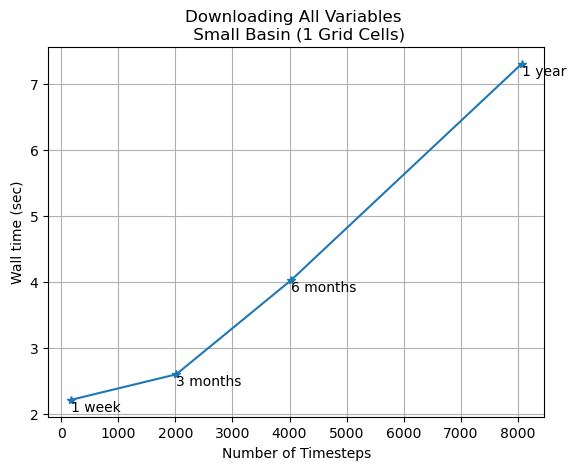

In [10]:
# ------ Data access execution
# ----------------------------

# create empty list to save the time periods and their associated execution times
x = []
y = []

# define different time periods
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]

# loop over different timesteps and measure the execution time
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.isel(latitude=3000, longitude=1000, time=range(0,ts)).compute()
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Small Basin (1 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

#### Medium-sized domain (5,760 km2)

1.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


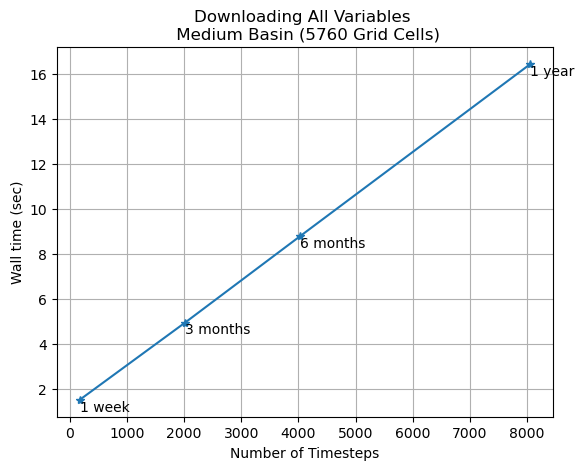

In [11]:
# ------ Data access execution
# ----------------------------
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(40.21, 40.71),longitude=slice(-111.7, -110.9)).isel(time=range(0,ts)).compute() 
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Medium Basin (5760 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

#### Large-sized domain (992,420 km2)

Please note that, in this specific scenario, we did not assess computational time beyond one month timesteps due to limitations in available memory.

7.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
37.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
37.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


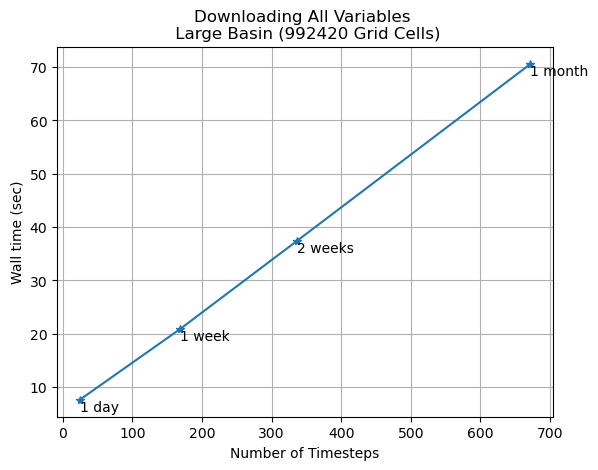

In [8]:
# ------ Data access execution
# ----------------------------
x = []
y = []
timesteps = [24, 24*7, 24*7*2, 24*7*4]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  res = %timeit -n1 -r1 -o ds.sel(latitude=slice(36.048020187527, 41.8308079035245),longitude=slice(-121.32196958368947, -109.40336130407586)).isel(time=range(0,ts)).compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Large Basin (992420 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 day', '1 week', '2 weeks', '1 month']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

## C. Cloud-based Computation Performance Assessment

The following codes cells assess the wall time required to access data in the cloud, **perform additional calculations on the cloud**, and subsequently return the results to memory over **different time periods**, including one week (24 hours * 7 days), 12 weeks (24 hours * 7 days * 12 weeks), 24 weeks (24 hours * 7 days * 24 weeks), and 48 weeks. This assessment is performed for **three different scenarios**: a small domain covering one grid cell with the size of 1 km2, a medium-sized domain approximately equivalent to the size of a Hydrologic Unit Code (HUC) 12 area, and a large domain approximately equivalent to an entire HUC 2 region.

#### Example 1: Calculate Spatially Averaged Daily Precipitation

This example illustrates how a user can **resample** hourly precipitation to daily precipitation and subsequently calculate the **average precipitation** across a specified area. 

In the small-sized scenario, we initially select hourly data for the specified location (grid cell) and then calcualte daily precipitation using Python's `groupby` function. 

261 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
447 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
620 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
966 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


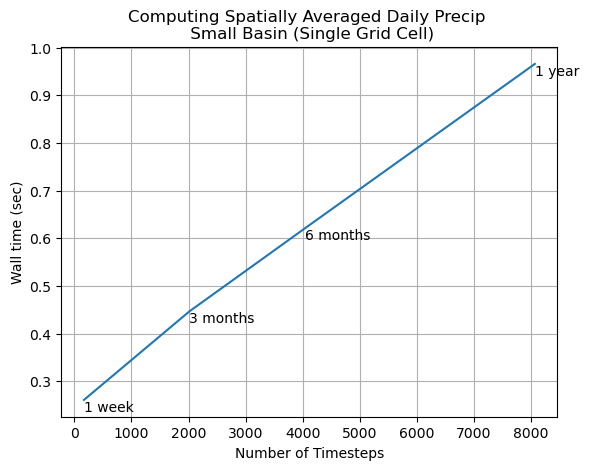

In [15]:
# ------ Data access and temporal resampling execution
# ----------------------------------------------------
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.isel(latitude=3000, longitude=1000, time=range(0,ts)).APCP_surface.groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------------------------------
plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Small Basin (Single Grid Cell)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

In both medium- and large-sized scenarios, our first step involves selecting hourly data for designated domain. Following that, we calculate the spatially averaged hourly precipitation across the entire domain using `.mean(dim=['latitude', 'longitude'])`. Then, we use Python's groupby function to compute daily preciptiation. Note that all calculations are conducted on the cloud and then results is returned back to the memory. 

350 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
658 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
888 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


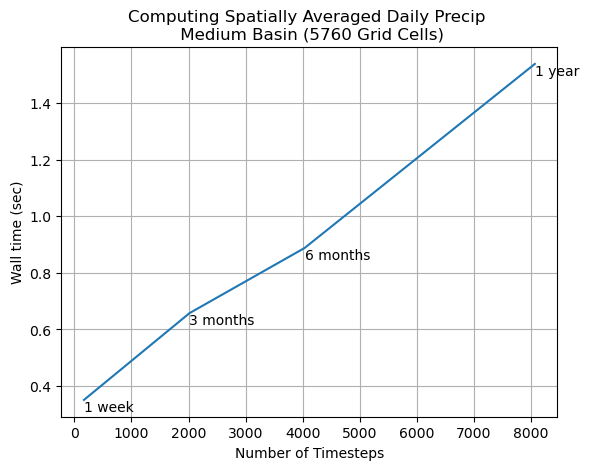

In [16]:
# ------ Data access, temporal resampling, and spatial averaging execution
# ------------------------------------------------------------------------
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(40.21, 40.71),longitude=slice(-111.7, -110.9)).isel(time=range(0,ts)).APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------------------------------
plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Medium Basin (5760 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

1.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
13.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
25.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


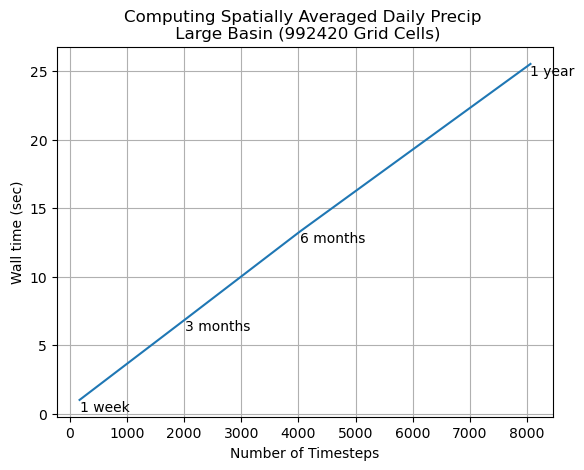

In [17]:
# ------ Data access, temporal resampling, and spatial averaging execution
# ------------------------------------------------------------------------
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(36.048020187527, 41.8308079035245),longitude=slice(-121.32196958368947, -109.40336130407586)).isel(time=range(0,ts)).APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------ Visualization
# ----------------------------------------------------
plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Large Basin (992420 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()


#### Example 2: Subset Data via Geometry for Regional Analysis

This is another instance of performing computations in the cloud. In this example, our objective is to extract a subset of the complete dataset corresponding to a specific geographical domain. Instead of specifying the bounding box using `ds.sel` and defining latitude and longitude `slices`, we choose a widely adopted approach commonly used when working with distributed national-scale datasets such as AORC. This method is especially beneficial for users involved in **regional analysis**, as it uses the geometry information for the study domain. 

The following code reads a simple geometry dataframe from a pickle file named 'geometry_df.pkl' and displays the coordinate reference system information linked to the geometry data within that dataframe.

In [18]:
gdf = pd.read_pickle('geometry_df.pkl')
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Please note that this version of AORC data (version 1.1) contains spatial metadata (latitude and longitude). So, there is no need to manually incorporate these into the dataset, as was necessary for AORC version 1.0. However, version 1.1 lacks a defined **Coordinate Reference System** (CRS), and this information must be appended separately. This becomes crucial when subsetting the dataset based on geometry information obtained from a geometry file.

In [22]:
# create a copy of a small chunk of data to work with
dat = ds.sel(time=slice('2020-01-01', '2020-02-01')).copy(deep=True)
print(f'CRS exists -> {dat.rio.crs is not None}')

CRS exists -> False


Add CRS from the `gfd.crs` to the dataset, recognizing that it is 'EPSG:4326'

In [23]:
dat.rio.write_crs('EPSG:4326', inplace=True)
print(f'CRS exists -> {dat.rio.crs is not None}')

CRS exists -> True


Subset the data using the `clip` function from `rioxarray` Python package, ensuring alignment with the geometries specified in the geodataframe.

In [24]:
%%time
clipped = dat.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False, from_disk=True)

CPU times: user 1.98 s, sys: 385 ms, total: 2.36 s
Wall time: 2.28 s


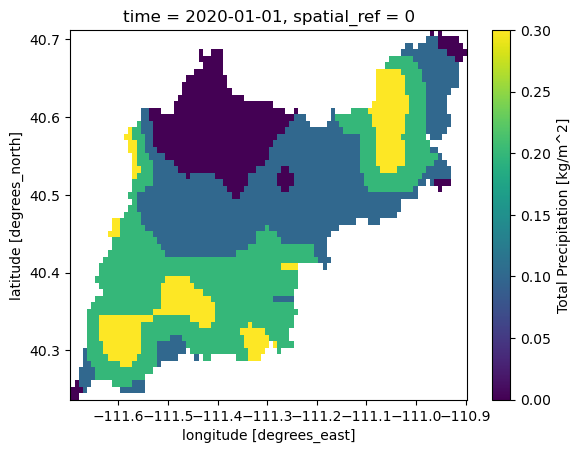

In [25]:
# plot the result for one timestep
_ = clipped.isel(time=0).APCP_surface.plot()